In [1]:
import rdkit
import numpy as np
from rdkit import Chem
import pandas as pd
import torch
import copy
import EcConf as ecconf
from tqdm import tqdm
from rdkit.Chem import Descriptors
import re

from sklearn.model_selection import train_test_split

import pickle

In [2]:
from rdkit.Chem.rdchem import BondType as BT

BOND_TYPES = {t: i for i, t in enumerate(BT.names.values())}
from torch_scatter import scatter
from torch_geometric.data import Data

In [18]:
from rdkit import Chem 
from rdkit.Chem import AllChem
from EcConf.utils.utils_np import *
from EcConf.comparm import *
import copy
import torch 
import networkx as nx
from EcConf.utils.utils_graphroute import *
from EcConf.utils.utils_rdkit import *
from EcConf.graphs.datasets import MG_Dataset
import random 

class Molgraph:
    def __init__(self, rdkitmol, coordinating_atom_inds,
                 boltzmannweight = None, totalenergy = None,
                 atom_type = None, edge_index = None,
                 edge_type = None, idx = None, smiles='',
                 RemoveHs=True):
        self.smiles=smiles
        self.atoms=[atom.GetAtomicNum() for atom in rdkitmol.GetAtoms()] #每一个原子的边个数
        self.atoms=np.array(self.atoms)
        self.chiraltags=[GP.chiral_types.index(atom.GetChiralTag()) for atom in rdkitmol.GetAtoms()]
        self.chiraltags=np.array(self.chiraltags)
        self.natoms=len(self.atoms)
        self.adjs=np.zeros((self.natoms,self.natoms))
        self.coordinating_atom_inds = coordinating_atom_inds
        
        #增加boltzmannweight，totalenergy字段，用于标识构象在分子中的位置
        self.boltzmannweight = boltzmannweight
        self.totalenergy     = totalenergy
        self.atom_type       = atom_type
        self.edge_index      = edge_index #这个是局部编号的，里面的原子编号是从0开始到|all_atoms| - 1, 所以该值可以不保存，但也没问题，因为早晚都要局部编号的
        self.edge_type       = edge_type
        self.idx             = idx
        
            
        for bond in rdkitmol.GetBonds():
            a1=bond.GetBeginAtom().GetIdx()
            a2=bond.GetEndAtom().GetIdx()
            bt=bond.GetBondType() 
            ch=GP.bond_types.index(bt)
            if int(ch) == 4:
                ch = 1 #reclassify aromatics as single bonds
            if int(ch) == 3:
                ch = 2 #reclassify triple bonds as double bonds
            self.adjs[a1,a2]=ch+1
            self.adjs[a2,a1]=ch+1
        #self.zmats=np_adjs_to_zmat(adjs_onek)
        # modified by Kento, add a bond type that represents a hyper-edge between the metal and all ligand atoms
        self.adjs[-1,:-1] = 3
        self.adjs[:-1,-1] = 3
        self.coords=np.array(rdkitmol.GetConformer(0).GetPositions())
        self.Standardrize()
        return 
    
    def RemoveHs(self):
        noH_idx = np.array([i for i in range(len(self.atoms)) if self.atoms[i] != 1])
        n_heavy_atoms = len(noH_idx)
        coords = self.coords[noH_idx]
        adjs = self.adjs[np.ix_(noH_idx,noH_idx)]
        self.atoms = self.atoms[noH_idx]

        self.adjs = adjs
        self.chiraltags = self.chiraltags[noH_idx]        
        self.coords = coords
        self.natoms = n_heavy_atoms
        return
    
    def PermIndex(self,mode='random'):
        if mode=='random':
            start_id = random.choice(np.arange(self.natoms).astype(int))
        else:
            start_id = 0
        graph = nx.Graph()
        bonds = []
        for i in range(self.natoms):
            for j in range(i+1,self.natoms):
                if self.adjs[i,j] != 0:
                    bonds.append((i,j))
        graph.add_edges_from(bonds)
        atom_order = bfs_seq(graph,start_id)
        if len(atom_order) < self.natoms:
            atom_order += [self.natoms-1]
        assert len(set(atom_order)) == self.natoms
        self.coordinating_atom_inds = np.array([list(atom_order).index(prev_idx) for prev_idx in self.coordinating_atom_inds])
        self.metal_ind = list(atom_order).index(self.natoms-1)
        self.atoms = self.atoms[np.ix_(atom_order)]
        self.chiraltags = self.chiraltags[np.ix_(atom_order)]
        self.coords = self.coords[np.ix_(atom_order)]
        self.adjs = self.adjs[np.ix_(atom_order,atom_order)]
        return
     
    def Generate_Zmats(self):
        adjs_onek = Adjs_to_Onek(self.adjs)
        zmats = np_adjs_to_zmat(adjs_onek)[:,:4]
        return zmats
    
    def Standardrize(self):
        # self.RemoveHs() # removed by Kento 5/3 -> assume that H's are all removed already
        # self.PermIndex(mode='random')
        self.PermIndex(0)
        self.zmats = self.Generate_Zmats()
        return 

    def Get_3D_Graph_Tensor(self,max_atoms= None):
        if max_atoms:
            adjs = torch.zeros((max_atoms,max_atoms)).long()
            zmats = torch.zeros((max_atoms,4)).long()
            coords = torch.zeros((max_atoms,3))
            masks = torch.zeros(max_atoms).bool()
            masks[:self.natoms] = True
            if not GP.if_chiral:
                atom_idx = torch.zeros(max_atoms).long()
                atom_chiraltags = torch.zeros(max_atoms).long()
                atom_idx_ = Atoms_to_Idx(self.atoms,GP.atom_types)
                atom_idx[:self.natoms] = torch.Tensor(atom_idx_).long()
                atom_chiraltags[:self.natoms] = torch.Tensor(self.chiraltags).long()
            else:
                atom_idx = torch.zeros((max_atoms,len(GP.atom_types)))
                atom_chiraltags = torch.zeros((max_atoms,len(GP.chiral_types)))
                atom_idx_ = Atoms_to_Onek(self.atoms,GP.atom_types)
                #print (self.__dict__.keys())
                atom_chiraltags_ = Chiraltag_to_Onek(self.chiraltags,GP.chiral_types)
                atom_idx[:self.natoms] = torch.Tensor(atom_idx_)
                atom_chiraltags[:self.natoms] = torch.Tensor(atom_chiraltags_)
            #print (self.natoms,self.atoms,self.zmats,self.adjs)
            zmats[:self.natoms] = torch.Tensor(self.zmats).long()
            adjs[:self.natoms,:self.natoms] = torch.Tensor(self.adjs).long()
            coords[:self.natoms] = torch.Tensor(self.coords)
            return atom_idx, atom_chiraltags, adjs, coords, zmats, masks
        else:
            #print (self.natoms)
            atom_idx_ = Atoms_to_Idx(self.atoms,GP.atom_types)
            return torch.Tensor(atom_idx_).long(),torch.Tensor(self.chiraltags),torch.Tensor(self.adjs).long(),torch.Tensor(self.coords),torch.Tensor(self.zmats).long(),torch.ones(self.natoms).bool()    

    
    def Trans_to_Rdkitmol(self):
        molecule=Chem.RWMol()
        for j in range(self.natoms):
            new_atom=Chem.Atom(int(self.atoms[j]))
            molecule_idx=molecule.AddAtom(new_atom)
        adjs=copy.deepcopy(self.adjs)
        row,col=np.diag_indices_from(adjs)
        adjs[row,col]=0
        idx1,idx2=np.where(adjs!=0)
        for id1,id2 in zip(idx1,idx2):
            if id1<id2:
                molecule.AddBond(int(id1),int(id2),GP.bond_types[int(adjs[id1,id2])-1])
        mol=molecule.GetMol()
        Chem.SanitizeMol(mol)
        AllChem.Compute2DCoords(mol)
        mol=Change_mol_xyz(mol,self.coords)
        return mol
    def Update_Coords(self,coords):
        self.coords=coords

def Adjs_to_Onek(adjs,nchannels=3):
    # nchannels=int(np.max(adjs)-1)
    #nchannels=5 # switched to 5 for single, double, triple, aromatic, metal-hyper-edge
    adjs_onek=np.zeros((adjs.shape[0],adjs.shape[0],nchannels))
    idx1,idx2=np.where(adjs)
    channel_idx=adjs[idx1,idx2].astype(int)-1
    for id1,id2,cid in zip(idx1,idx2,channel_idx):
        adjs_onek[id1,id2,cid]=1
    return adjs_onek.astype(int)

def Atoms_to_Idx(atoms,possible_atom_types=[1,6,7,8,9,15,16,17,35,53]):
    atom_idx_=[possible_atom_types.index(int(a))+1 for a in atoms] 
    return atom_idx_

def Atoms_to_Onek(atoms,possible_atom_types=[1,6,7,8,9,15,16,17,35,53]):
    atoms_onek=np.zeros((len(atoms),len(possible_atom_types)))
    for i in range(len(atoms)):
        atoms_onek[i][possible_atom_types.index(atoms[i])]=1
    return atoms_onek.astype(int)

def Chiraltag_to_Onek(chiraltags,chiral_types=[ ChiralType.CHI_UNSPECIFIED, ChiralType.CHI_TETRAHEDRAL_CW, ChiralType.CHI_TETRAHEDRAL_CCW, ChiralType.CHI_OTHER, ChiralType.CHI_TETRAHEDRAL, ChiralType.CHI_ALLENE, ChiralType.CHI_SQUAREPLANAR, ChiralType.CHI_TRIGONALBIPYRAMIDAL,ChiralType.CHI_OCTAHEDRAL]):
    ntags=len(chiral_types)
    chiral_onek=np.zeros((len(chiraltags),ntags))
    for i in range(len(chiraltags)):
        chiral_onek[i][chiraltags[i]]=1
    return chiral_onek.astype(int)

In [4]:
df = pd.read_csv('scripts/GEMO/metal/ligand_properties_unique_hash.csv')
df

,Ligand_mol2_Strings,Ligand_mol2_Strings_without_X,Ligand_mol2_Strings_without_H,Ligand_mol2_Strings_without_XH,Ligand_Denticities,Graph_Hash_Ligand,Graph_Hash_Ligand_without_X,Graph_Hash_Ligand_without_H,Graph_Hash_Ligand_without_XH,Hemilabile,Connecting_Atom_Indices,Connecting_Atom_Indices_without_H,Connecting_Atom_Indices_without_X,Connecting_Atom_Indices_without_XH,SMILES_without_X_molsimplify,SMILES_without_X_rdkit,Occurrences
0,@<TRIPOS>MOLECULE\nligand\n15\t15\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n14\t14\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n11\t11\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n10\t10\t1\nSMALL\nPartial...,1,1c7ad85f17b9eff49fe72b778c3c34f6,3e9c127ae89c7d7c70476bc3edd0146d,de1136ccc9f1a20bb65275e3db4200d1,cf794afe3aca095cb66e4686e2c400e9,True,[11],[7],[11],[7],Clc1cccc(c1)C(=O)[O],O=C([O-])c1cccc(Cl)c1,33
1,@<TRIPOS>MOLECULE\nligand\n4\t3\t1\nSMALL\nPar...,@<TRIPOS>MOLECULE\n\n3\t2\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n2\t1\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n1\t0\t1\nSMALL\nPartialCh...,1,de39b424f3c3457188364891b9317dba,e5206dd18f7e829cf77fae1a48e7b0b9,d4f3d1d61e49aeb0a0ac5b8b146d86cc,de75f5edfabdb0477e652512e4287161,False,[0],[0],[0],[0],O,O,34348
2,@<TRIPOS>MOLECULE\nligand\n21\t22\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n20\t19\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t9\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t6\t1\nSMALL\nPartialCh...,3,d750f0dd3c8f3f3239ca016adc2e4fd8,03da74c428d73bd0cce03611bc1912b2,4973f8f4fe2953d0cd36790f18f93ec6,0c891e5805b76e96da6ba1df9bddd4b5,True,"[1, 4, 13]","[1, 4, 7]","[0, 3, 12]","[0, 3, 6]",NCCNCCN,NCCNCCN,729
3,@<TRIPOS>MOLECULE\nligand\n15\t15\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n14\t14\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t8\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t7\t1\nSMALL\nPartialCh...,1,b96a9c7f7079d2d2d6f17e3c963742ce,6f7dcaf05c67ea0280785c1da69f60be,3f4a40869b0294b5c284a65d20a3b274,92988d01351387cb00626cb5652e8fc3,True,[0],[0],[0],[0],CC1=CC=[C]C=C1,Cc1cc[c]cc1,175
4,@<TRIPOS>MOLECULE\nligand\n12\t13\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n11\t11\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t9\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t7\t1\nSMALL\nPartialCh...,2,04297c886adca1ea304eed3f9ee37da5,78571a62707b266b7547ec8fad857d32,3e1ceb0125d14567937ae2291ce697a7,e491c8dae119d25956bda1315728fc54,True,"[9, 11]","[5, 7]","[9, 10]","[5, 6]",S=C1[CH]C=CC=N1,[S-]c1ccccn1,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89000,@<TRIPOS>MOLECULE\nligand\n46\t49\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n45\t48\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n22\t25\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n21\t24\t1\nSMALL\nPartial...,1,a9d8815901b8fe07feac4ebaa10280dd,2d1c13307bbaa2f8d1563559cd4acaaa,877f0f6cc99780fb11892703fe197c06,78cff3bf59b1560083f1c6cce802ba5b,False,[1],[1],[0],[0],CN(Cc1ccccc1[Sn]c1ccccc1CN(C)C)C,C[N+]1(C)Cc2ccccc2[Sn]12c1ccccc1C[N+]2(C)C,1
89001,@<TRIPOS>MOLECULE\nligand\n80\t89\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n79\t83\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n47\t56\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n46\t50\t1\nSMALL\nPartial...,6,ebd68466a75793f3f46039240272d66f,ff84b3ef5aa5619abab198c90e2efba4,c3fa132c0426a579caa00911a9d03a9e,e35d05c891d93eb4a27f9b1ee90f46e2,False,"[14, 15, 17, 19, 16, 18]","[9, 10, 12, 14, 11, 13]","[13, 14, 16, 18, 15, 17]","[8, 9, 11, 13, 10, 12]",O/N=C(/c1ccccn1)\C.S=C=N[Dy](O/N=C(/c1ccccn1)\...,CC1=[N+](O)[Dy+9]([OH2+])([OH2+])(N=C=S)(O/N=C...,1
89002,@<TRIPOS>MOLECULE\nligand\n80\t89\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n79\t86\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n52\t61\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n51\t58\t1\nSMALL\nPartial...,3,476a09f1a3c2dea0cda24b0b1143ae2c,c6f02d3ea23b6335d311a8849a383594,e4ef0dc8b445b7d54a56374eaab3da27,f8977f0ffcc416c10a4cf14077bce6d6,False,"[1, 6, 7]","[1, 6, 7]","[0, 5, 6]","[0, 5, 6]",C1=C[C]=C(C=C1)P(c1ccccc1)c1ccccc1.Clc1c2O[Sb]...,Clc1c(Cl)c(Cl)c2c(c1Cl)O[Sb+](c1ccccc1P(c1cccc...,1
89003,@<TRIPOS>MOLE

In [5]:
# Need to figure out if we want to do any splits with the denticities
sum(df['Ligand_Denticities'] <= 2)

49637

In [5]:
def get_metal_coords_from_mol2(mol2block):
    for s in mol2block.split('\n'):
        if 'X1' in s:
            coords = np.array([float(p) for p in s.split('\t')[1].split()[:3]])
    return coords

def mol_with_metal(mol2block, mol2block_with_metal):
    mol = Chem.MolFromMol2Block(mol2block)
    m = Chem.RWMol(mol)
    metal_idx = m.AddAtom(Chem.Atom(26))
    coords = get_metal_coords_from_mol2(mol2block_with_metal)
    m.GetConformer().SetAtomPosition(metal_idx, coords)
    return m.GetMol()

In [6]:
labels = []
mol_ls = []
for i, x in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = mol_with_metal(x['Ligand_mol2_Strings_without_X'], x['Ligand_mol2_Strings'])
        label_ls = [int(j) for j in x['Connecting_Atom_Indices_without_XH'].strip('[]').replace(',', '').split()]
        mol_ls.append(mol)
        labels.append(label_ls)
    except:
        pass
len(mol_ls)

100%|██████████| 89005/89005 [02:10<00:00, 683.03it/s]


80528

In [7]:
allowed_atoms = {1, 5, 6, 7, 8, 9, 15, 16, 17, 35, 53, 26}
filtered_mol_ls = []
filtered_labels = []
for i in tqdm(range(len(mol_ls))):
    atom_list = [a.GetAtomicNum() for a in mol_ls[i].GetAtoms()]
    if set(atom_list).issubset(allowed_atoms) and \
        Descriptors.NumRadicalElectrons(mol_ls[i]) == 0 and\
        len(atom_list) > 2 and \
        Chem.GetFormalCharge(mol_ls[i]) <= 2 and Chem.GetFormalCharge(mol_ls[i]) >= -4 and \
        len(atom_list) <= 50:
        filtered_mol_ls.append(mol_ls[i])
        filtered_labels.append(labels[i])
len(filtered_mol_ls)

100%|██████████| 80528/80528 [00:10<00:00, 7564.99it/s]


50104

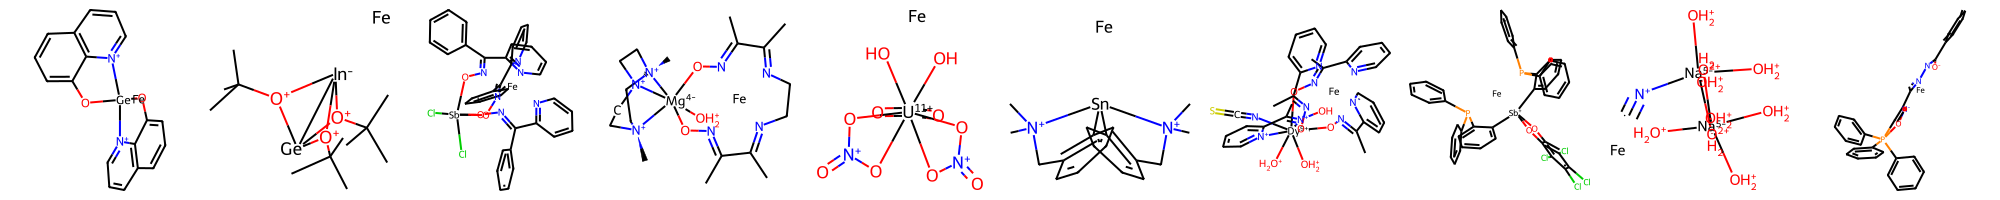

In [10]:
Chem.Draw.MolsToImage(mol_ls[-10:])

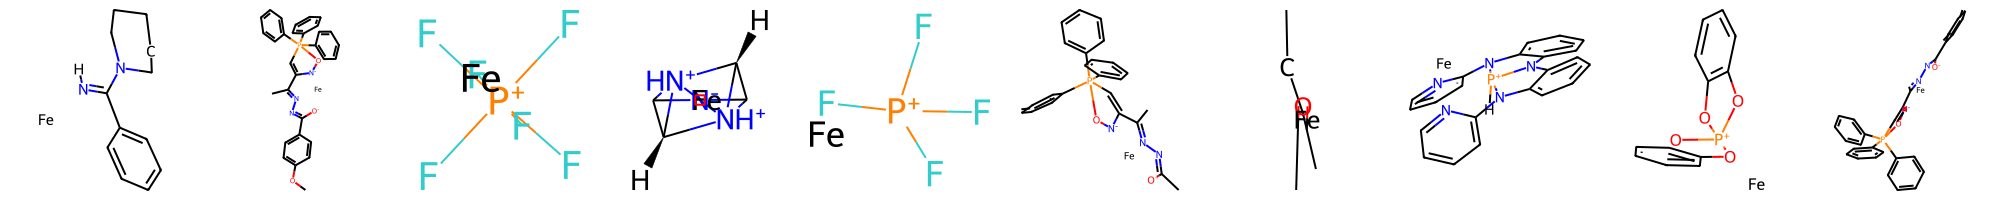

In [11]:
Chem.Draw.MolsToImage(filtered_mol_ls[-10:])

In [19]:
molgraph_ls = []
for i in tqdm(range(len(filtered_mol_ls))):
    try:
        mg = Molgraph(filtered_mol_ls[i], filtered_labels[i])
        mg.Get_3D_Graph_Tensor(50)
        molgraph_ls.append(mg)
    except:
        pass
print(len(molgraph_ls))

100%|██████████| 50104/50104 [01:15<00:00, 663.38it/s]

50069


In [20]:
idxs = np.arange(len(molgraph_ls))
np.random.shuffle(idxs)

In [21]:
train_idxs = idxs[:int(np.ceil(0.8*len(idxs)))]
val_idxs = idxs[int(np.ceil(0.8*len(idxs))): int(np.ceil(0.9*len(idxs)))]
test_idxs = idxs[int(np.ceil(0.9*len(idxs))):]

In [22]:
train_molgraphs = np.array(molgraph_ls)[train_idxs]
test_molgraphs = np.array(molgraph_ls)[test_idxs]
val_molgraphs = np.array(molgraph_ls)[val_idxs]

In [13]:
torch.save(train_molgraphs, './scripts/GEMO/metal/train_molgraphs_ls.pt')
torch.save(test_molgraphs, './scripts/GEMO/metal/test_molgraphs_ls.pt')
torch.save(val_molgraphs, './scripts/GEMO/metal/val_molgraphs_ls.pt')

In [14]:
train_molgraphs = torch.load('./scripts/GEMO/metal/train_molgraphs_ls.pt')
test_molgraphs = torch.load('./scripts/GEMO/metal/test_molgraphs_ls.pt')
val_molgraphs = torch.load('./scripts/GEMO/metal/val_molgraphs_ls.pt')

In [23]:
# make sure it works
train_dataset = MG_Dataset(train_molgraphs, 'train')
#for i in range(22253,len(train_dataset)):
#    train_dataset.__getitem__(i)

In [24]:
train_molgraphs[0].metal_ind, train_molgraphs[0].coordinating_atom_inds

(2, array([ 4, 19, 21]))

In [25]:
train_dataset.__getitem__(0)

{'Feats': tensor([ 3,  3, 12,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          4,  4,  4,  4,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 'Adjs': tensor([[0, 1, 3,  ..., 0, 0, 0],
         [1, 0, 3,  ..., 0, 0, 0],
         [3, 3, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'Coords': tensor([[ 1.8038e+01,  4.4933e+00,  6.1583e+00],
         [ 1.8430e+01,  3.4030e+00,  7.1120e+00],
         [ 2.1554e+01,  3.6718e+00,  6.6684e+00],
         [ 1.7515e+01,  2.7200e+00,  7.8560e+00],
         [ 1.9725e+01,  2.8593e+00,  7.1806e+00],
         [ 1.9719e+01,  1.7101e+00,  7.8783e+00],
         [ 2.1721e+01,  7.5080e-01,  7.2400e+00],
         [ 2.2513e+01, -4.3530e-01,  6.8652e+00],
         [ 2.2323e+01, -1.7865e+00,  7.1435e+00],
         [ 2.3182e+01, -2.6722e+00,  6.5516e+00],
         [ 2.4209e

In [26]:
import torch
from EcConf.model.equiformer import * 
from EcConf.model.consistency import * 
import pickle,os,tempfile, shutil, zipfile, time, math, tqdm 
from datetime import datetime 
from EcConf.comparm import * 
from EcConf.utils.utils_torch import *
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
from EcConf.graphs.datasets import *
from tqdm import tqdm 

from torch import distributed as dist
import gc

import random
import numpy as np

def IC_Loss(pred,target,zmats,gmasks):
    pred_bonddis,pred_angle,pred_dihedral,j1,j2,j3=xyz2ic(pred,zmats) #笛卡尔转内坐标
    target_bonddis,target_angle,target_dihedral,j1,j2,j3=xyz2ic(target,zmats)
    pred_dismat=torch.cdist(pred,pred,compute_mode='donot_use_mm_for_euclid_dist')
    target_dismat=torch.cdist(target,target,compute_mode='donot_use_mm_for_euclid_dist')
    gmasks_2D=gmasks.unsqueeze(-1)*gmasks.unsqueeze(-1).permute(0,2,1)
    loss_angle=F.mse_loss(pred_angle[gmasks],target_angle[gmasks])
    loss_dismat=F.mse_loss(pred_dismat[gmasks_2D],target_dismat[gmasks_2D])
    loss_bonddis=F.mse_loss(pred_bonddis[gmasks],target_bonddis[gmasks])
    dihedral_diff=torch.abs(pred_dihedral[gmasks]-target_dihedral[gmasks])
    dihedral_diff=torch.where(dihedral_diff>math.pi,math.pi*2-dihedral_diff,dihedral_diff)
    loss_dihedral=torch.mean(torch.square(dihedral_diff))
    return loss_dismat,loss_bonddis,loss_angle,loss_dihedral


def RMSD_Loss(pred,target,zmats,gmasks):
    #pred
    bond,angle,dihedral,*_ = xyz2ic(pred,zmats)   
    pred_aligned = ic2xyz(bond,angle,dihedral,zmats) #将笛卡尔坐标与内坐标对齐？
    
    #target
    bond,angle,dihedral,*_ = xyz2ic(target,zmats)
    target_aligned = ic2xyz(bond,angle,dihedral,zmats) #将笛卡尔坐标与内坐标对齐？
    
     
    loss = (pred_aligned - target_aligned)**2
    loss = torch.sum(loss, dim=-1, keepdim=True).mean()
    
    return loss

In [27]:
test_data = train_dataset.__getitem__(0)

IC_Loss(test_data['Coords'], test_data['Coords'], test_data['Zmats'], test_data['Masks'])

IndexError: index out of range in self

In [18]:
def np_adjs_to_ctable(adjs):
    ctable=np.sum(adjs,axis=-1).astype(float)
    #print (ctable)
    ctable[0,0]=1
    if len(ctable)>2:
        #print ('ctable',ctable[0,2])
        if ctable[0,2]==0:
            #print ('ctable',ctable[0,2])
            ctable[0,2]=0.5
            ctable[2,0]=0.5
        #print ('ctable',ctable[0,2])
        
        if ctable[1,2]==0:
            ctable[1,2]=0.5
            ctable[2,1]=0.5
    return ctable

In [21]:
onek = Adjs_to_Onek(molgraph_ls[0].adjs, nchannels=5)
np_adjs_to_ctable(onek)

array([[1. , 1. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0.5, 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0.5, 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 1. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. ],
       [0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. ]])